In [1]:
import sys
# sys.path.insert(0, "effdet")
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
import pickle
from effdet_old import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet_old.efficientdet import HeadNet
from ensemble_boxes import *
SEED = 42
import gc
from torchvision import transforms as T
import matplotlib.pyplot as plt
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

In [142]:
label_codes = {
"Pedestrian": 0,
"Biker": 1,
"Car": 2,
"Bus": 3,
"Skater": 4,
"Cart": 5
}
label_colors = {
1: (255,0,0),
2:(0,255,0),
3: (0,0,255),
 4: (255,255,0),
5:(0,255,255),
6:(255,255,255)
}

In [3]:
transforms =  A.Compose([
#                 A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=1),
#             A.RandomCrop(512, 512),
#             A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)



In [4]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = transforms(image=image)
            image = sample['image']
        return image,image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [149]:
np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')])

225948

In [5]:
DATA_ROOT_PATH = '/mnt/r4/aliev/stanford_voc/VOC2012/JPEGImages'
dataset = DatasetRetriever(
    image_ids=np.array([path.split('/')[-1][:-4] for path in glob(f'{DATA_ROOT_PATH}/*.jpg')]),
    transforms=transforms
)

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=False,
    num_workers=4,
    drop_last=False,
    collate_fn=collate_fn
)

In [94]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d1')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 6
    config.image_size=512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()


net = load_net('effdet1_loss_1_42_batch12_state_dict.pt')

In [122]:
def make_predictions(images, score_threshold=0.2):
    images = images.cuda().float()
    predictions = []
    with torch.no_grad():
        print("shape of input: ",images.shape)
        det = net(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            labels = det[i].detach().cpu().numpy()[:,5]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
                'labels': labels[indexes]
            })
    return [predictions],det

def run_wbf(predictions, image_size=512, iou_thr=0.15, skip_box_thr=0.15, weights=None):
    boxes = [(prediction['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction['scores'].tolist()  for prediction in predictions]
    labels = [prediction['labels'].tolist()  for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [154]:
# fname = '/mnt/r4/aliev/stanford_voc/VOC2012/JPEGImages/hyang_video3_400.jpg'
fname = '/mnt/r4/aliev/stanford_voc/VOC2012/JPEGImages/bookstore_video1_400.jpg'
t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])

frame = cv2.imread(fname, cv2.IMREAD_COLOR)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
if frame.shape[0]<1024:
    frame = frame[:frame.shape[0],:frame.shape[0]]
    frame = cv2.resize(frame, (1024,1024))
frame = cv2.resize(frame, (512,512))



shape of input:  torch.Size([1, 3, 512, 512])


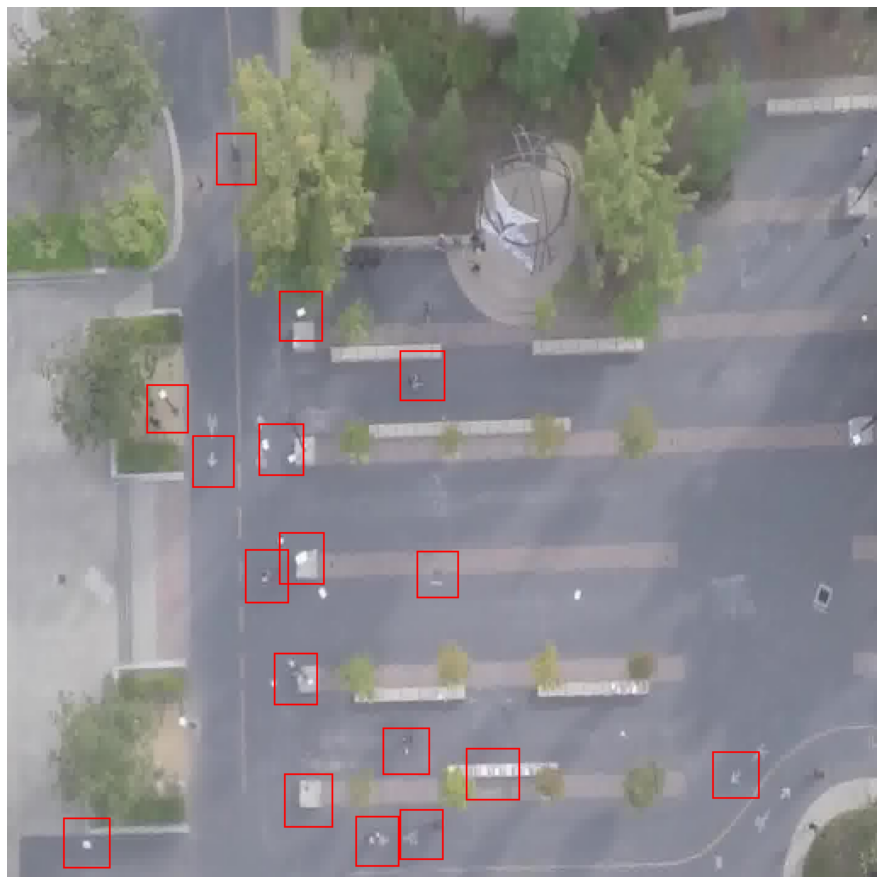

In [155]:
image = t(frame).unsqueeze(0)


predictions,det = make_predictions(image)


# frame
boxes, scores, labels = run_wbf(predictions[0])
boxes = boxes.astype(np.int32).clip(min=0, max=511)
for box,label in zip(boxes,labels):
    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), label_colors[label], 1)

fig, ax = plt.subplots(1, 1, figsize=(20, 16))
ax.set_axis_off()
ax.imshow(frame)

In [73]:
predictions

[[{'boxes': array([], shape=(0, 4), dtype=float32),
   'scores': array([], dtype=float32),
   'labels': array([], dtype=float32)}]]

In [72]:
[(prediction['boxes'])  for prediction in predictions]

TypeError: list indices must be integers or slices, not str

In [103]:
image = t(frame)
batch = torch.zeros((4,3,512,512),dtype=torch.float32)
batch[0] = image[:,:512,:512]
batch[1] = image[:,512:1024,:512]
batch[2] = image[:,:512,512:1024]
batch[3] = image[:,512:1024,512:1024]
batch = batch.cuda().float()
predictions,det = make_predictions(batch)
patch = [None,None,None,None]
patch[0] = frame[:512,:512]
patch[1] = frame[512:1024,:512]
patch[2] = frame[:512,512:1024]
patch[3] = frame[512:1024,512:1024]

for i in range(4):
    boxes, scores, labels = run_wbf([predictions[i]])
    boxes = boxes.astype(np.int32).clip(min=0, max=511)
    for box,label in zip(boxes,labels):
        cv2.rectangle(patch[i], (box[0], box[1]), (box[2], box[3]), label_colors[label], 1)

fig, ax = plt.subplots(1, 1, figsize=(20, 16))
ax.set_axis_off()
ax.imshow(frame)


RuntimeError: The expanded size of the tensor (512) must match the existing size (0) at non-singleton dimension 1.  Target sizes: [3, 512, 512].  Tensor sizes: [3, 0, 512]